In [301]:
# Packages import

import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import glob
import random
import pywt
from pywt import wavedec, dwt
from sporco.admm import tvl1
from sporco.admm import tvl2
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import os, sys
from itertools import product
from PIL import Image
import sporco
from sporco.admm import bpdn
import cv2
from skimage.measure import compare_ssim as ssim


/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/charlesdognin/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


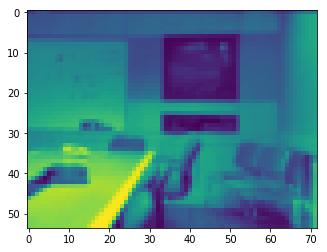

In [288]:
# Data import

x_train = []
x_test = []

for image_path in glob.glob("/Users/charlesdognin/Desktop/compressed_sensing/MovedObject/train_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.45)
    image = image / 255
    x_train.append(image)

for image_path in glob.glob("/Users/charlesdognin/Desktop/compressed_sensing/MovedObject/test_dataset/*.bmp"):
    image = misc.imread(image_path, mode = "L")
    image = misc.imresize(image, 0.45)
    image = image / 255
    x_test.append(image)

x_train = np.stack(x_train)
x_test = np.stack(x_test)

# Showing an example image 

plt.imshow(x_train[0]);
plt.show()

In [319]:
def wavelet_dec(row, threshold=0.5):
    coeffs = np.concatenate(dwt(row, 'haar'))
    return pywt.threshold(coeffs, threshold, 'hard')

def compressive_measurements(x, r, rand_type = "gauss", power = 2):
    """
    Takes an image as argument and return a dictionnary with the vector of measurement, the 
    measurement matrix and the original reshaped image. 
    
    Arguments:
    r -- sparsity parameter (between 0 and 1)
    x -- the original or compressed image
    
    Returns: 
    y -- vector of dimension (M = r * N)
    A -- matrix of dimension (M x N)
    x -- original image with shape (N, 1)
    """
    
    random.seed(10) # Setting seed for reproductibility
    
    nx, ny = x.shape
    x = x.reshape(1, -1).T
    N = nx * ny 
    M = round(N * r) 
    
    if rand_type == "student":
        phi = np.random.standard_t(power, size=(M, N))
    else:
        phi = np.random.randn(M, N)
        phi = np.multiply(np.power(np.absolute(phi),power), np.sign(phi))   
        
        
    A = np.apply_along_axis(wavelet_dec, axis=1, arr=phi)
    
    y =  np.dot(A, x)
    
    cm = {"measurement_matrix": A, 
          "compressive_samples": y, 
        "original_image_vector": x,
         "original_dimensions": (nx, ny)} 
    
    return cm
    
def signal_reconstruction(cm, lmbda1 = 0.1, lmbda2 = 8e-1):
    """
    Signal recovery using the Basis Pursuit Denoising (BPDN) as in the article. We use the 
    L1-TV denoising algorithm to recover a more 
    
    Arguments:
    phi -- the measurement matrix of size (M x N)
    y -- the measurement vector of size (M x 1)
    lambda: the hyperparameter controlling the L1 penalization
    
    Returns:
    x -- the recovered signal from optimization of size (N)
    e -- the reconstruction error from original image  
    """
    
    A, y, x0 = cm["measurement_matrix"], cm["compressive_samples"], cm["original_image_vector"]
    M = len(y)
    N = A.shape[1]

    opt1 = bpdn.BPDN.Options()
        
    # Run optimisation
    x = bpdn.BPDN(A, y, lmbda1, opt1)
    x_hat = x.solve()
    x_hat = x_hat.reshape(cm["original_dimensions"])
    opt2 = tvl1.TVL1Denoise.Options()
        
    # Initialise and run TVL1Denoise object
    b1 = tvl1.TVL1Denoise(x_hat, lmbda2, opt2)
    imgr = b1.solve()
    
    return x_hat, imgr

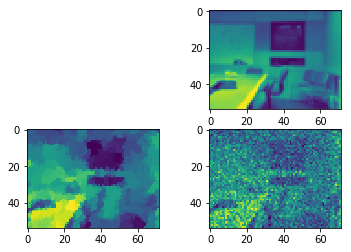

In [324]:
cm = compressive_measurements(x_train[0], 0.95)
x_hat, imgr = signal_reconstruction(cm, lmbda1 = 0.1, lmbda2 = 8e-1)

plt.subplot(222)
plt.imshow(x_train[0]);
plt.subplot(223)
plt.imshow(imgr);
plt.subplot(224)
plt.imshow(x_hat);
plt.show()

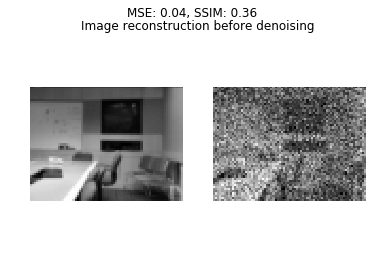

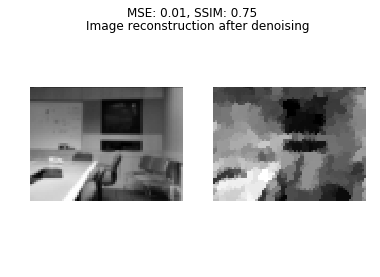

In [325]:
def mse(imageA, imageB):
    
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err
 
def compare_images(imageA, imageB, title):
    m = mse(imageA, imageB) # between 0 and +infty (0 best)
    s = ssim(imageA, imageB) # between -1 and 1 (1 best)
 
    # setup the figure
    fig = plt.figure()
    plt.title(title)
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s))
    plt.axis("off")
 
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = plt.cm.gray)
    plt.axis("off")
 
    # show the images
    plt.show()

compare_images(x_train[0], x_hat, "Image reconstruction before denoising");
compare_images(x_train[0],imgr, "Image reconstruction after denoising");


In [ ]:
def background_constraint_model(y_sample):
    mu_b = np.mean(y_train, axis=0)
    l2_distance = np.sum((y_sample - mu_b) ** 2)
    sigma_bg
    mu_bg
    return sigma_bg, mu_bg

In [45]:
class object_detector(object):

    def __init__(x_background, x_test):
        pass

    
    
    